In [1]:
import pandas as pd
import math

df = pd.read_csv("Test.csv")

df.head()

,Name
0,AARTHI S
1,ABIRAMI E
2,AGNES A
3,Ajaykumar R
4,AKSHAY ANIL KUMAR


In [2]:
num_rows = len(df)
num_qubits = math.ceil(math.log2(num_rows))

print(f"Total rows: {num_rows}")
print(f"Qubits required: {num_qubits}")


Total rows: 183
Qubits required: 8


In [3]:
df = df.reset_index().rename(columns={"index": "RowIndex"})

df["BinaryIndex"] = df["RowIndex"].apply(
    lambda x: format(x, f"0{num_qubits}b")
)

df.head()


,RowIndex,Name,BinaryIndex
0,0,AARTHI S,00000000
1,1,ABIRAMI E,00000001
2,2,AGNES A,00000010
3,3,Ajaykumar R,00000011
4,4,AKSHAY ANIL KUMAR,00000100


In [4]:
mapping = {
    row["BinaryIndex"]: row.drop(["RowIndex", "BinaryIndex"]).to_dict()
    for _, row in df.iterrows()
}

for k, v in list(mapping.items())[:5]:
    print(f"{k} -> {v}")


00000000 -> {'Name': 'AARTHI S'}
00000001 -> {'Name': 'ABIRAMI E'}
00000010 -> {'Name': 'AGNES A'}
00000011 -> {'Name': 'Ajaykumar R'}
00000100 -> {'Name': 'AKSHAY ANIL KUMAR'}


In [5]:

search_column = "Name"      
search_value = "SAI PRASATH B"      


target_rows = df[df[search_column] == search_value]

if target_rows.empty:
    print(f"No match found for {search_value} in column {search_column}")
else:
    print(f" Match found:\n{target_rows}")

    # Get RowIndex and BinaryIndex of first match
    target_row = target_rows.iloc[0]
    target_binary = target_row["BinaryIndex"]

    print(f"\nTarget Binary Index: {target_binary}")
    print(f"Target Row Data: {target_row.to_dict()}")


 Match found:
     RowIndex           Name BinaryIndex
137       137  SAI PRASATH B    10001001

Target Binary Index: 10001001
Target Row Data: {'RowIndex': 137, 'Name': 'SAI PRASATH B', 'BinaryIndex': '10001001'}


In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import MCXGate

# Oracle builder compatible with Qiskit v2.0.3
def build_oracle(target_binary: str) -> QuantumCircuit:
    num_qubits = len(target_binary)
    oracle = QuantumCircuit(num_qubits)

    # Flip bits where target is '0' (little-endian order handling)
    for i, bit in enumerate(reversed(target_binary)):
        if bit == '0':
            oracle.x(i)

    # Apply multi-controlled Z via MCX wrapped by H on target qubit
    oracle.h(num_qubits - 1)
    oracle.append(MCXGate(num_qubits - 1), list(range(num_qubits)))
    oracle.h(num_qubits - 1)

    # Undo the flips
    for i, bit in enumerate(reversed(target_binary)):
        if bit == '0':
            oracle.x(i)

    oracle.name = "Oracle"
    return oracle


In [7]:
from qiskit import QuantumCircuit

def build_diffuser(num_qubits: int) -> QuantumCircuit:
    diffuser = QuantumCircuit(num_qubits)

    # Inversion about the mean
    diffuser.h(range(num_qubits))
    diffuser.x(range(num_qubits))
    diffuser.h(num_qubits - 1)
    diffuser.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    diffuser.h(num_qubits - 1)
    diffuser.x(range(num_qubits))
    diffuser.h(range(num_qubits))

    diffuser.name = "Diffuser"
    return diffuser


Running Grover with 13 iterations


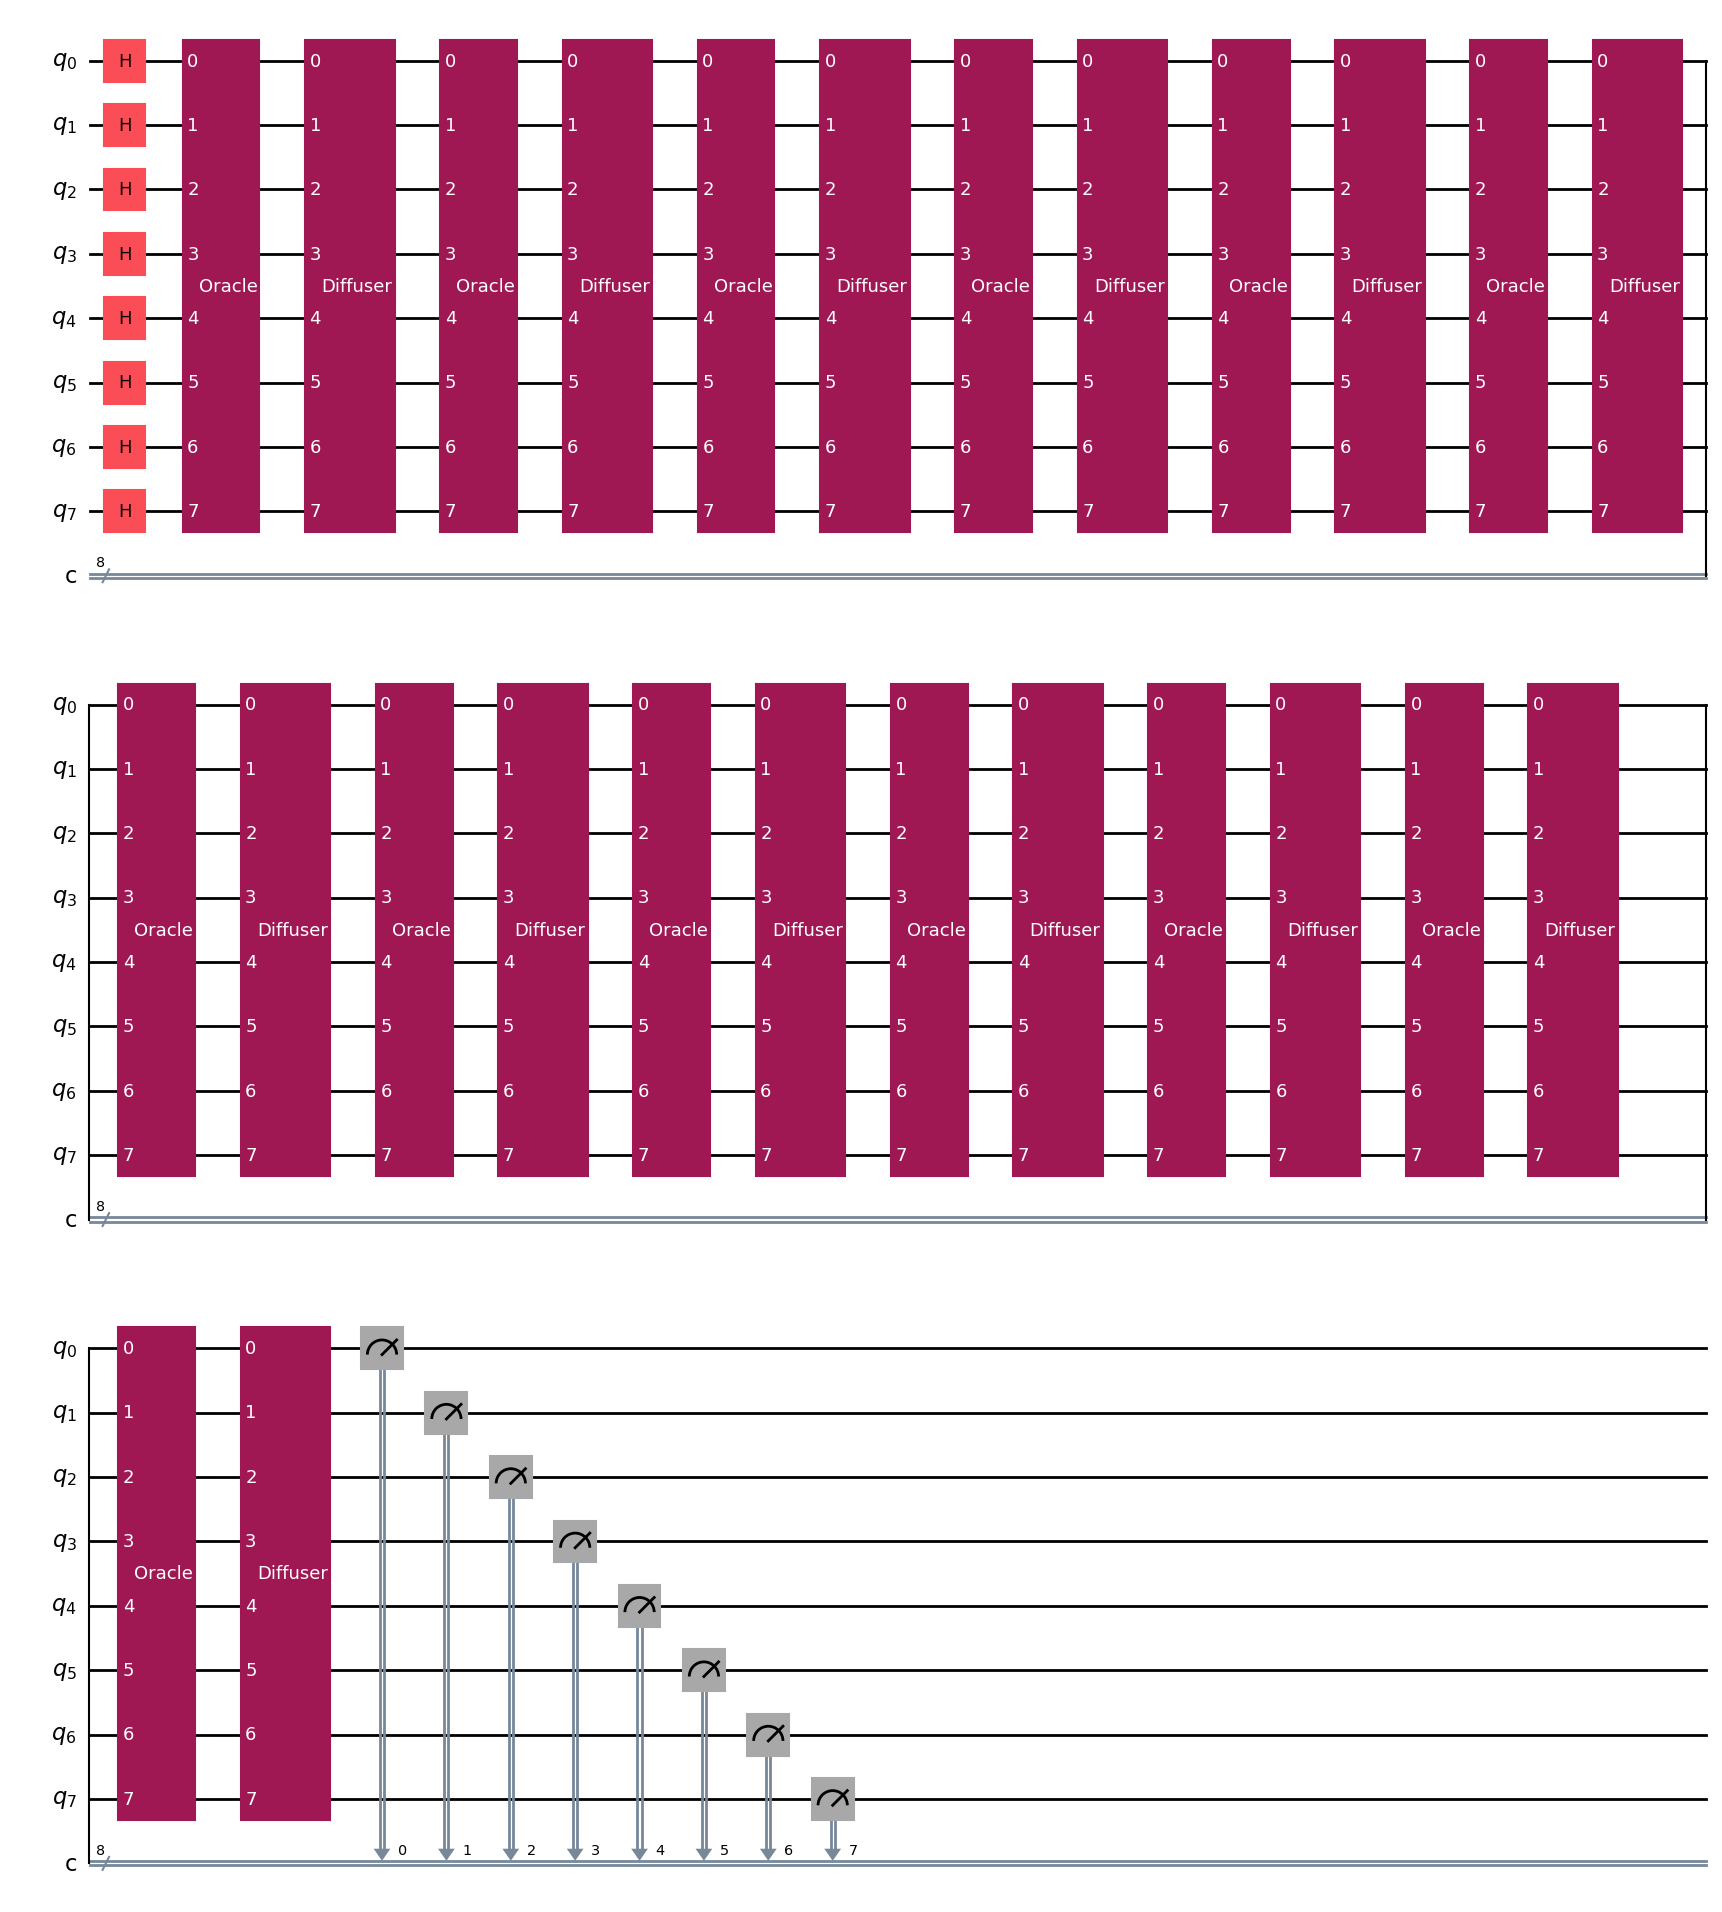

In [8]:
from qiskit_aer import Aer   # Aer is separate in Qiskit 2.x
from qiskit import transpile
from math import pi, sqrt

# Number of qubits (from your target_binary string)
num_qubits = len(target_binary)

# Build oracle and diffuser
oracle = build_oracle(target_binary)
diffuser = build_diffuser(num_qubits)

# Initialize Grover circuit with classical bits for measurement
grover = QuantumCircuit(num_qubits, num_qubits)

# 1. Superposition initialization
grover.h(range(num_qubits))

# 2. Determine number of iterations (~ π/4 * √N)
iterations = round(pi/4 * sqrt(2**num_qubits))
print(f"Running Grover with {iterations} iterations")

# 3. Apply Grover iterations: Oracle + Diffuser
for _ in range(iterations):
    grover.append(oracle, range(num_qubits))
    grover.append(diffuser, range(num_qubits))

# 4. Measurement
grover.measure(range(num_qubits), range(num_qubits))

# Visualize circuit
grover.draw("mpl")


Result counts: {'11010001': 1, '01101010': 1, '10001000': 1, '11100101': 1, '01011000': 1, '11001110': 1, '11011001': 1, '10001001': 1012, '11000000': 1, '11011000': 1, '11001101': 1, '00110101': 1, '01111010': 1}


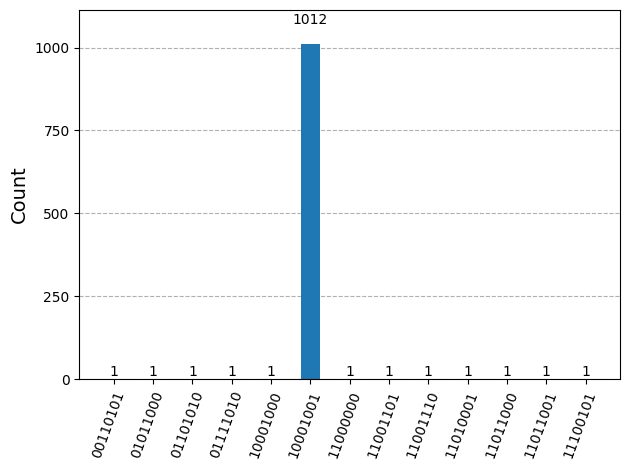

In [9]:
from qiskit.visualization import plot_histogram

# Run on Qiskit Aer simulator (Qiskit 2.x style)
sim = Aer.get_backend('qasm_simulator')
compiled = transpile(grover, sim)
result = sim.run(compiled, shots=1024).result()

# Get measurement results
counts = result.get_counts()
print("Result counts:", counts)

# Plot histogram of outcomes
plot_histogram(counts)


In [10]:
# === Step 10: Map Grover's Output to CSV Data ===

# Find the most frequent binary result
most_common_binary = max(counts, key=counts.get)
print(f"Most frequent measured binary index: {most_common_binary}")

# Map back to original row
row_data = mapping.get(most_common_binary, None)

if row_data:
    print(" Corresponding row found in CSV:")
    print(row_data)
else:
    print(" No matching row found in mapping.")


Most frequent measured binary index: 10001001
 Corresponding row found in CSV:
{'Name': 'SAI PRASATH B'}
